In [24]:
'''
Experiment - Mapping a source color palette in RGB to a target color palette

Data:
    - A set of source and target colors in RGB
    
Objectives:
    - Map the source palette to the target palette
    - Optimize the source palette to capture inter color relationships of target palette in terms of luminosity,
    hue, saturation
    
Note:
    - In this experiment, properties have been independently optimized
'''

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from colour import Color

In [25]:
# Palette Generators

palette_dict = {
    'grey': ['#1b1c1d', '#3e464e', '#616970', '#b6bcc2', '#f2f6f9'],
	'nautical': ['#172f97', '#e8f103', '#f9f4f4', '#cc0e08', '#070707'],
	'summer': ['#aceaff', '#7dd2f8', '#fbea61', '#f8dd00', '#f9c800'],
	'primadonna': ['#e562ab', '#bf5088', '#7e295d', '#691751', '#420d38'],
	'maisie': ['#fde9e9', '#feffa8', '#eab886', '#6f452e', '#514307'],
	'knight': ['#3d007c', '#ffc100', '#818181', '#000a9a', '#000000'],
	'wedding': ['#d69fa2', '#eee2dd', '#827c78', '#6e6259', '#64313e'],
	'scourge': ['#ff0000', '#ecd470', '#a9791d', '#bbbbbb', '#2f2f2f']
}

def generate_random_palette(size):
    return np.random.rand(size, 3)

def get_palette(name):
    return np.array([[c.red, c.green, c.blue] for c in map(lambda hex: Color(hex), palette_dict[name])])

def get_random_pair_from_dict():
    keys = list(palette_dict.keys())
    temp = np.arange(len(keys))
    np.random.shuffle(temp)
    return tuple(map(lambda idx: get_palette(keys[idx]), temp[:2]))

def get_prominance(size):
    p = np.random.rand(size)
    return np.sort(p).reshape(-1, 1)[::-1] / np.sum(p)

In [26]:
# Palette Visualizations

def viz_palette(palette, title=''):
    '''Plot the colors in a palette'''
    
    fig = plt.figure(figsize=(6, 1), frameon=False)
    ax = fig.add_subplot(111)
    for i, col in enumerate(palette):
        patch = mpl.patches.Rectangle((i, 0), 1, 1, facecolor=col)
        ax.add_patch(patch)
    ax.set_xlim((0, len(palette)))
    ax.set_ylim((0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.set_title(title)

def viz_points_1D(source, target, orig=None, xlabel=''):
    '''Plot a 1D event plot of a single dimension'''
    
    source_, target_ = np.copy(source), np.copy(target)
    fig = plt.figure(figsize=(6, 1))
    ax = fig.add_subplot(111)
    ax.set_xlim((0, 1))
    ax.set_ylim((0.5, 1.5))
    ax.set_yticks([])
    ax.set_xlabel(xlabel)
    ax.eventplot(source_, orientation='horizontal', colors='b')
    ax.eventplot(target_, orientation='horizontal', colors='r')
    if orig is not None:
        orig_ = np.copy(orig)
        ax.eventplot(orig_, orientation='horizontal', colors='y')
    for i in range(source.shape[0]):
        ax.annotate(i+1, (target[i], 1.3))
        ax.annotate(i+1, (source[i], 0.9))
        if orig is not None:
            ax.annotate(i+1, (orig[i], 0.6))
    
def viz_points_2D(source, target, orig=None, xlabel='', ylabel=''):
    '''Plot a 2D scatter plot of 2 dimensions'''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(source[:,0], source[:,1], c='b')
    ax.scatter(target[:,0], target[:,1], c='r')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if orig is not None:
        ax.scatter(orig[:,0], orig[:,1], c='y')
    for i in range(source.shape[0]):
        ax.annotate(i+1, target[i])
        ax.annotate(i+1, source[i])
        if orig is not None:
            ax.annotate(i+1, orig[i])

def viz_costs(costs):
    '''Plot the cost function'''
    plt.plot(costs)
    plt.xlabel('iterations')
    plt.ylabel('cost')

In [27]:
def check_gradients(param, fn, grads, epsilon=1e-4, threshold=1e-7):
    '''
    Approximately compute expected gradients of a function wrt each paramter and check it against 
    the computed gradients
    Report threshold breaches
    fn must expect param as its only argument
    '''
    params_shape = param.shape
    param = param.reshape(-1) # Flatenning parameters
    
    # Approx grads
    grads_approx = np.zeros_like(param)
    for i in range(param.size):
        orig = param[i]
        param[i] = orig - epsilon
        fn_l = fn(param.reshape(params_shape))
        param[i] = orig + epsilon
        fn_r = fn(param.reshape(params_shape))
        param[i] = orig
        grads_approx[i] = (fn_r - fn_l) / (2*epsilon)
    
    # Diff norm
    norm = np.linalg.norm(grads.reshape(params_shape) - grads_approx.reshape(params_shape))
    
    if norm > threshold:
        print('Violation: Norm:{}, Threshold:{}'.format(norm, threshold))
        print('param', param.reshape(params_shape))
        print('grad', grads.reshape(params_shape))
        print('grad approx', grads_approx.reshape(params_shape))
        print('grad diff', (grads.reshape(params_shape) - grads_approx.reshape(params_shape)))
        return False
    else:
        print('No Violation: ', norm)
        return True

In [28]:
class LuminosityOptimizer:
    
    def __init__(self, target):
        self.target = target # rgb
        self.target_l = self.get_l(target) #luminosity
        self.target_l = np.sort(self.target_l, axis=0)
    
    @staticmethod
    def get_l(rgb):
        '''Covert rgb to luminosity'''
        return 0.2126 * rgb[:,0] + 0.7152 * rgb[:,1] + 0.0722 * rgb[:,2]

    @staticmethod
    def get_l_grads(rgb):
        '''Gradients of luminosity wrt rgb'''
        return np.ones_like(rgb) * np.array([0.2126, 0.7152, 0.0722]).reshape(1,3)
    
    @staticmethod
    def _check_l_grads():
        '''Gradient checking for luminosity gradients'''
        palette = generate_random_palette(1000)
        l = LuminosityOptimizer(palette)
        for rgb, grad in zip(palette, l.get_l_grads(palette)):
            check_gradients(rgb.reshape(1, rgb.size), l.get_l, grad.reshape(1, rgb.size))
            
    def get_cost(self, source):
        '''
        Optimizes luminosity of source to match target values
        This function is useful only for gradient checking, get_cng also computes cost and should be used 
        instead while optimizing to avoid redundant computations
        '''
        source_l = self.get_l(source)
        source_idx = source_l.argsort()
        diff_l = source_l[source_idx] - self.target_l
        return np.sum(np.square(diff_l)) / (2*source.size)
    
    def get_cng(self, source):
        '''Get cost and gradients of cost function wrt source rgb'''
        source_l = self.get_l(source)
        source_idx = source_l.argsort()
        diff_l = source_l[source_idx] - self.target_l
        cost = np.sum(np.square(diff_l)) / (2*source.size)
        cost_grads = diff_l / source.size
        cost_grads = cost_grads[source_idx.argsort()].reshape(-1, 1)
        dsource = self.get_l_grads(source) * cost_grads
        return cost, dsource
    
    def _check_grads():
        '''Gradient checking for cost function'''
        for _ in range(1000):
            src = generate_random_palette(10)
            tgt = generate_random_palette(10)
            l = LuminosityOptimizer(tgt)
            _, grads = l.get_cng(src)
            if not check_gradients(src, l.get_cost, grads, epsilon=1e-7, threshold=1e-9):
                print('Target:', tgt)
                
if False:
    LuminosityOptimizer._check_l_grads()
    LuminosityOptimizer._check_grads()

In [29]:
class HueOptimizer:
    
    def __init__(self, target):
        self.target = target
        self.target_h = self.get_h(target)
        self.target_h = np.sort(self.target_h, axis=0)
    
    @staticmethod
    def get_h(rgb):
        '''Convert rgb to hue'''
        hue = np.zeros((rgb.shape[0]))
        for i, col in enumerate(rgb):
            r, g, b = rgb[i]
            mx = max(r, g, b)
            mn = min(r, g, b)
            c = mx - mn # chroma
            if c == 0:
                h = 0
            elif mx == r:
                h = ((g - b) / c) + (6 if g < b else 0)
            elif mx == g:
                h = ((b - r) / c) + 2
            else:
                h = ((r - g) / c) + 4
            hue[i] = h / 6
        return hue
        
    @staticmethod
    def get_h_grads(rgb):
        '''Compute gradients of hue wrt rgb'''
        drgb = np.zeros_like(rgb)
        for i, col in enumerate(rgb):
            r, g, b = rgb[i]
            mx = max(r, g, b)
            mn = min(r, g, b)
            c = mx - mn # chroma
            if c == 0:
                drgb[i] = 0
                continue    
            if mx == r:
                temp = (g - b) / (c * c)
                drgb[i][0] = -1 * temp
                drgb[i][1] = 1 / c
                if mn == g:
                    drgb[i][1] += temp
                drgb[i][2] = -1 / c
                if mn == b:
                    drgb[i][2] += temp
            elif mx == g:
                temp = (b - r) / (c * c)
                drgb[i][1] = -1 * temp
                drgb[i][2] = 1 / c
                if mn == b:
                    drgb[i][2] += temp
                drgb[i][0] = -1 / c
                if mn == r:
                    drgb[i][0] += temp
            else:
                temp = (r - g) / (c * c)
                drgb[i][2] = -1 * temp
                drgb[i][0] = 1 / c
                if mn == r:
                    drgb[i][0] += temp
                drgb[i][1] = -1 / c
                if mn == g:
                    drgb[i][1] += temp
        return drgb / 6
    
    @staticmethod
    def _check_h_grads():        
        '''Gradient checking for hue gradients'''
        palette = generate_random_palette(10000)
        h = HueOptimizer(palette)
        for rgb, grad in zip(palette, h.get_h_grads(palette)):
            check_gradients(rgb.reshape(1, rgb.size), h.get_h, grad.reshape(1, rgb.size), epsilon=1e-7, threshold=1e-7)
            
    def get_cost(self, source):
        '''
        Optimizes hue of source to match target values
        Note: Hue values range from 0 to 1 (0 to 360 scaled). However, values 0 and 1 correspond to the same hue.
        In general, we cannot take the difference in hue value as a measure of true difference in hue. Here, since
        we are independently optimizing hue, we have to deal with 2 cases:
            1) In sorted source, the first point is mapped to the first point in the sorted target (remaining mapping
            follows)
            2) In sorted source, the first point is mapped to the last point in the sorted target
        We pick the mapping with lower cost
        '''
        
        source_h = self.get_h(source)
        
        # Source point 1 is mapped to target point 1
        source_idx = source_h.argsort()
        source_h1 = source_h[source_idx]
        diff_h = source_h1 - self.target_h
        cost = np.sum(np.square(diff_h)) / (2*source.size)
        
        # Source point 1 is mapped to target point N (last)
        source_idx2 = np.roll(source_idx, -1)
        source_h2 = source_h[source_idx2]
        diff2 = source_h2 - self.target_h
        cost2 = np.sum(np.square(diff2)) / (2*source.size)
        
        # Pick minimum cost
        return cost2 if cost2 < cost else cost
    
    def get_cng(self, source):
        '''Get cost and gradients of cost function wrt source rgb'''
        source_h = self.get_h(source)
        
        source_idx = source_h.argsort()
        source_h1 = source_h[source_idx]
        diff_h = source_h1 - self.target_h
        cost = np.sum(np.square(diff_h)) / (2*source.size)
        
        source_idx2 = np.roll(source_idx, -1)
        source_h2 = source_h[source_idx2]
        diff2 = source_h2 - self.target_h
        cost2 = np.sum(np.square(diff2)) / (2*source.size)
        
        if cost2 < cost:
            source_idx, diff_h, cost = source_idx2, diff2, cost2
            
        norm_grads = diff_h / source.size
        norm_grads = norm_grads[source_idx.argsort()].reshape(-1, 1)
        grads = self.get_h_grads(source) * norm_grads
        return cost, grads
    
    def _check_grads():
        '''Gradient checking for cost function'''
        for _ in range(100):
            src = generate_random_palette(100)
            tgt = generate_random_palette(100)
            h = HueOptimizer(tgt)
            _, grads = h.get_cng(src)
            check_gradients(src, h.get_cost, grads, epsilon=1e-7, threshold=1e-7)
        
if False:
    HueOptimizer._check_h_grads()
    HueOptimizer._check_grads()

In [30]:
class SaturationOptimizer:
    
    def __init__(self, target):
        self.target = target
        self.target_s = self.get_s(target)
        self.target_s = np.sort(self.target_s, axis=0)
    
    @staticmethod
    def get_s(rgb):
        '''Get saturation from rgb'''
        sat = np.zeros((rgb.shape[0]))
        mx, mn = np.max(rgb, axis=1), np.min(rgb, axis=1)
        c = mx - mn
        l = (mx + mn) / 2
        l_valid = np.logical_and(l > 0, l < 1)
        sat[l_valid] = c[l_valid] / (1 - np.abs((2*l[l_valid]) - 1))
        return sat
        
    @staticmethod
    def get_s_grads(rgb):
        '''Compute gradients of saturation wrt rgb'''
        drgb = np.zeros_like(rgb)
        for i, (r, g, b) in enumerate(rgb):
            mx, mn = max(r,g,b), min(r,g,b)
            c = mx - mn
            l = (mx + mn) / 2
            if l == 0 or l == 1:
                continue
            temp1 = 1 - abs((l*2) -1)
            temp2 = ((mx - mn)/(temp1*temp1))*(1 if (l*2) - 1 > 0 else -1)
            dmx = (1/temp1) + temp2
            dmn = (-1/temp1) + temp2
            mx_idx = {r:0, g:1, b:2}[mx]
            mn_idx = {r:0, g:1, b:2}[mn]
            drgb[i][mx_idx] = dmx
            drgb[i][mn_idx] = dmn
        return drgb

    @staticmethod
    def _check_s_grads():
        '''Gradient checking for hue gradients'''
        palette = generate_random_palette(1000)
        s = SaturationOptimizer(palette)
        for rgb, grad in zip(palette, s.get_s_grads(palette)):
            check_gradients(rgb.reshape(1, rgb.size), s.get_s, grad.reshape(1, rgb.size), epsilon=1e-7, threshold=1e-7)
            
    def get_cost(self, source):
        '''Optimizes saturation of source to match target values'''
        source_s = self.get_s(source)
        source_idx = source_s.argsort()
        diff_s = source_s[source_idx] - self.target_s
        return np.sum(np.square(diff_s)) / (2*source.size)
    
    def get_cng(self, source):
        '''Get cost and gradients of cost function wrt source rgb'''    
        source_s = self.get_s(source)
        source_idx = source_s.argsort()
        diff_s = source_s[source_idx] - self.target_s
        cost = np.sum(np.square(diff_s)) / (2*source.size)
        norm_grads = diff_s / source.size
        norm_grads = norm_grads[source_idx.argsort()].reshape(-1, 1)
        grads = self.get_s_grads(source) * norm_grads
        return cost, grads
    
    def _check_grads():
        '''Gradient checking for cost function'''
        for _ in range(1000):
            src = generate_random_palette(10)
            tgt = generate_random_palette(10)
            s = SaturationOptimizer(tgt)
            _, grads = s.get_cng(src)
            if not check_gradients(src, s.get_cost, grads, epsilon=1e-7, threshold=1e-7):
                print('Target:', tgt)
                
if False:
    SaturationOptimizer._check_s_grads()
    SaturationOptimizer._check_grads()

In [31]:
class ElasticityOptimizer:
    
    def __init__(self, source):
        self.source = source
        self.source_orig = np.copy(source)
    
    def get_cost(self, source):
        '''Minimize distance b/w source and target points to prevent source points moving too far'''
        return np.sum(np.square(source - self.source_orig)) / (2*source.size)
    
    def get_cng(self, source):
        '''Get cost and gradients of cost function wrt source rgb'''
        diff = source - self.source_orig
        cost = np.sum(np.square(diff)) / (2*source.size)
        grads = diff / source.size
        return cost, grads
    
    @staticmethod
    def _check_gradients():
        '''Gradient checking for cost function'''
        for _ in range(1000):
            src = generate_random_palette(100)
            orig = generate_random_palette(100)
            s = ElasticityOptimizer(orig)
            _, grads = s.get_cng(src)
            if not check_gradients(src, s.get_cost, grads):
                print('Target:', tgt)
                
if False:
    ElasticityOptimizer._check_gradients()

In [39]:
class ColorOptimizer:
    '''Combines luminonsity, hue, saturation and elastisity optimisers'''
    
    def __init__(self, source, target, weights={}):
        self.lo = LuminosityOptimizer(target)
        self.ho = HueOptimizer(target)
        self.so = SaturationOptimizer(target)
        self.eo = ElasticityOptimizer(source)

        # Weights
        self.weights = {
            'elasticity': 1,
            'hue': 1,
            'luminosity': 1,
            'saturation': 1
        }
        self.weights.update(weights)
        # Normalize weights
        _tot = sum(self.weights.values())
        for k in self.weights:
            self.weights[k] /= _tot
        
    def get_cost(self, source):
        '''Combined and weighted cost'''
        return (self.weights['luminosity'] * self.lo.get_cost(source) + 
                self.weights['hue'] * self.ho.get_cost(source) + 
                self.weights['saturation'] * self.so.get_cost(source) + 
                self.weights['elasticity'] * self.eo.get_cost(source))
    
    def get_cng(self, source):
        '''Cost and gradients of cost function wrt source'''
        cost_l, grad_l = self.lo.get_cng(source)
        cost_h, grad_h = self.ho.get_cng(source)
        cost_s, grad_s = self.so.get_cng(source)
        cost_e, grad_e = self.eo.get_cng(source)
        cost = (self.weights['luminosity'] * cost_l + 
                self.weights['hue'] * cost_h + 
                self.weights['saturation'] * cost_s + 
                self.weights['elasticity'] * cost_e)
        grad_src = (self.weights['luminosity'] * grad_l + 
                self.weights['hue'] * grad_h + 
                self.weights['saturation'] * grad_s + 
                self.weights['elasticity'] * grad_e)
        return cost, grad_src
    
    @staticmethod
    def _check_grads():
        '''Final gradients check'''
        for _ in range(1000):
            src = generate_random_palette(10)
            tgt = generate_random_palette(10)
            weights = {
                'luminosity': np.random.rand(),
                'hue': np.random.rand(),
                'saturation': np.random.rand(),
                'elasticity': np.random.rand(),
            }
            c = ColorOptimizer(src, tgt, weights=weights)
            _, grads = c.get_cng(src)
            if not check_gradients(src, c.get_cost, grads, epsilon=1e-7, threshold=1e-7):
                print('Target:', tgt)
        
if False:
    ColorOptimizer._check_grads()

In [40]:
def optimize(source, target, optimizer, num_iters=1, lr=0.1):
    '''Adjusts source to minimize cost function'''
    costs = []
    for i in range(num_iters):
        cost, grads = optimizer.get_cng(source)
        costs.append(cost)
        source = source - (lr * grads)
        source = np.minimum(np.maximum(source, 0), 1)
    return costs, grads, source

In [41]:
if True:
    # Random palettes
    palette_size = 5
    source_palette = generate_random_palette(palette_size)
    target_palette = generate_random_palette(palette_size)
    
    # Select palettes from dict
    #source_palette = get_palette('summer')
    #target_palette = get_palette('knight')

    # Random palette pair for dict
    #source_palette, target_palette = get_random_pair_from_dict()
    
    co = ColorOptimizer(source_palette, target_palette, {
        'elasticity': 0,
        'hue': 1,
        'luminosity': 1,
        'saturation': 0
    })
    costs, grads, new_palette = optimize(source_palette, target_palette, co, num_iters=1200, lr=0.3)

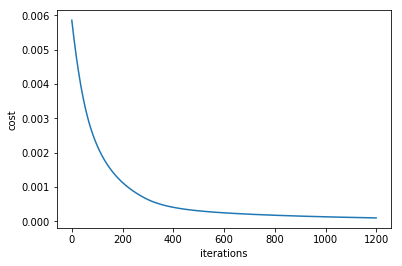

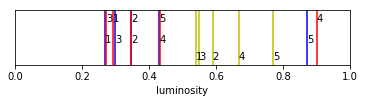

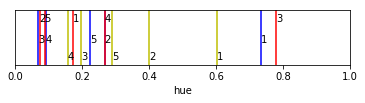

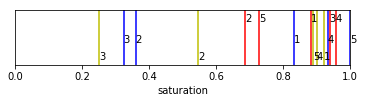

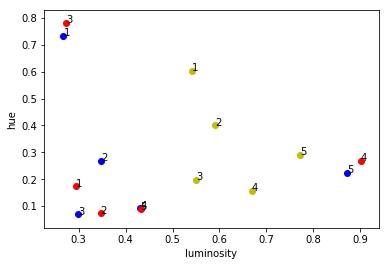

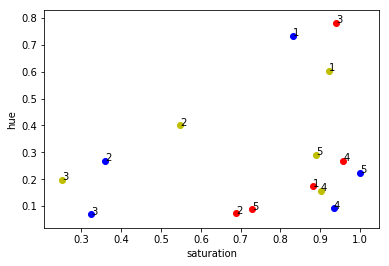

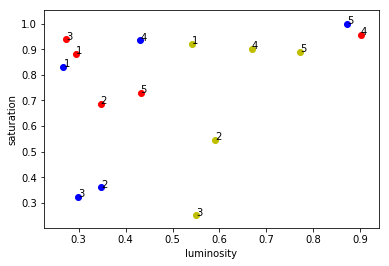

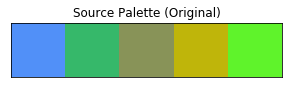

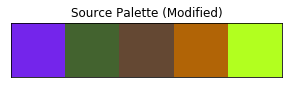

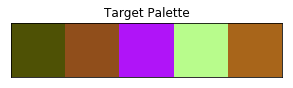

In [42]:
def visualize(costs, grads, source_orig, source_new, target):
    '''Visualuze palettes, learning curves, points, etc'''
    
    viz_costs(costs)
    
    ls, lso, lt = LuminosityOptimizer.get_l(source_new), LuminosityOptimizer.get_l(source_orig), LuminosityOptimizer.get_l(target)
    hs, hso, ht = HueOptimizer.get_h(source_new), HueOptimizer.get_h(source_orig), HueOptimizer.get_h(target)
    ss, sso, st = SaturationOptimizer.get_s(source_new), SaturationOptimizer.get_s(source_orig), SaturationOptimizer.get_s(target)
    
    viz_points_1D(ls, lt, orig=lso, xlabel='luminosity')
    viz_points_1D(hs, ht, orig=hso, xlabel='hue')
    viz_points_1D(ss, st, orig=sso, xlabel='saturation')
    
    viz_points_2D(np.array([ls, hs]).T, np.array([lt, ht]).T, orig=np.array([lso, hso]).T, xlabel='luminosity', ylabel='hue')
    viz_points_2D(np.array([ss, hs]).T, np.array([st, ht]).T, orig=np.array([sso, hso]).T, xlabel='saturation', ylabel='hue')
    viz_points_2D(np.array([ls, ss]).T, np.array([lt, st]).T, orig=np.array([lso, sso]).T, xlabel='luminosity', ylabel='saturation')
    
    viz_palette(source_orig, title='Source Palette (Original)')
    viz_palette(source_new, title='Source Palette (Modified)')
    viz_palette(target, title='Target Palette')
    
visualize(costs, grads, source_palette, new_palette, target_palette)